# SHAP Models (Logistic Regression, Random Forest, XGBoost)

### Logistic Regression

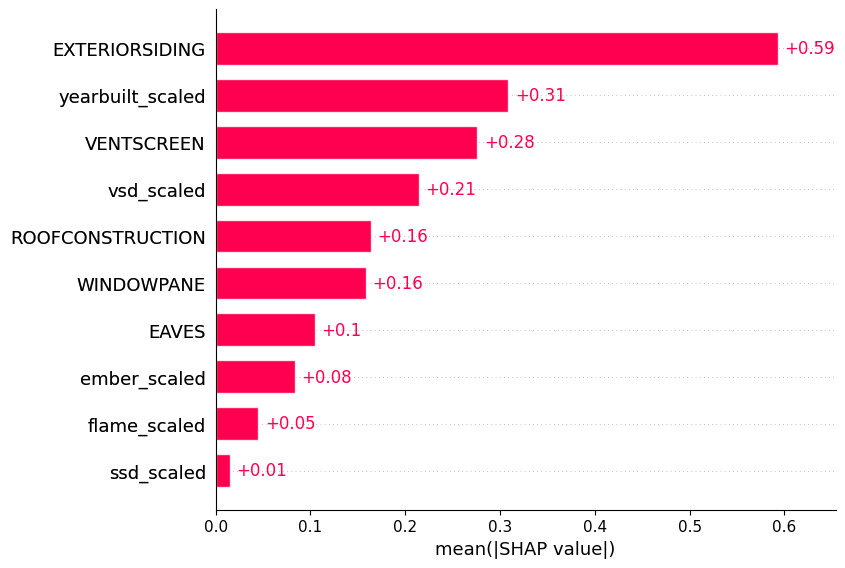

In [11]:
import os
import joblib
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

# Read datasets
with open("concatenated_df_ohe_targets_train_test_num_ready_data_binary.pkl", "rb") as file:
    data_dict = pickle.load(file)
    
# Load model
with open("logit_v0_using_numeric_features.pkl", "rb") as file:
    model_logit = pickle.load(file)

# Define X_test, y_test, X_train, y_train
X_test, y_test = data_dict["X_test"], data_dict["y_test"]
X_train, y_train = data_dict["X_train"], data_dict["y_train"]

def treat_encoded_shap_vals(sv, X, data_dict):
    shap_values = sv
    # reconstruct the original dataset before encoding
    X_cat_cols = data_dict["X_encoder"].get_feature_names_out().tolist()
    X_num_cols = ['yearbuilt_scaled', 'ssd_scaled', 'ember_scaled', 'flame_scaled', 'vsd_scaled'] 
    
    X_cat_original = data_dict["X_encoder"].inverse_transform(X[X_cat_cols])
    X_cat_original = pd.DataFrame(X_cat_original, columns=data_dict["X_encoder"].feature_names_in_)
    X_num_original = X.loc[:, X_num_cols].reset_index().drop(["index"], axis=1)
    X_original = X_cat_original.join(X_num_original)
    feature_names = X_cat_original.columns

    # get number of unique classes within each categorical data
    n_categories = []
    for f in feature_names[:-1]:
        n = X_cat_original[f].nunique()
        n_categories.append(n)

    # separating the shap values for categorical and numerical data
    # this part needs to be done according to the order of the 
    # features in axis=1.
    shap_values_cat = shap_values.values[:, :-len(X_num_cols)]
    shap_values_num = shap_values.values[:, -len(X_num_cols):]

    # replace the aggregated shap values for catgorical features
    new_shap_values_cat = []
    for values in shap_values_cat:        
        values_split = np.split(values , np.cumsum(n_categories))
        values_sum = [sum(vs) for vs in values_split]
        new_shap_values_cat.append(values_sum)
        
    new_shap_values_cat = np.array(new_shap_values_cat)
    new_shape_values = np.hstack((new_shap_values_cat, shap_values_num))
    shap_values.values = new_shape_values
    shap_values.data = X_original.values
    shap_values.feature_names = feature_names.to_list() + X_num_cols
    
    return shap_values, X_original 

# best model estimator
best_model_logit = model_logit['grid_search'].best_estimator_

# Create a SHAP explainer using the best model
explainer = shap.Explainer(best_model_logit, masker=X_test)

# Calculate SHAP values 
shap_values_exp = explainer(X_test)
shap_values, X_test_original = treat_encoded_shap_vals(shap_values_exp, X_test, data_dict)

shap.plots.bar(shap_values, max_display=20)


### Random Forest

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


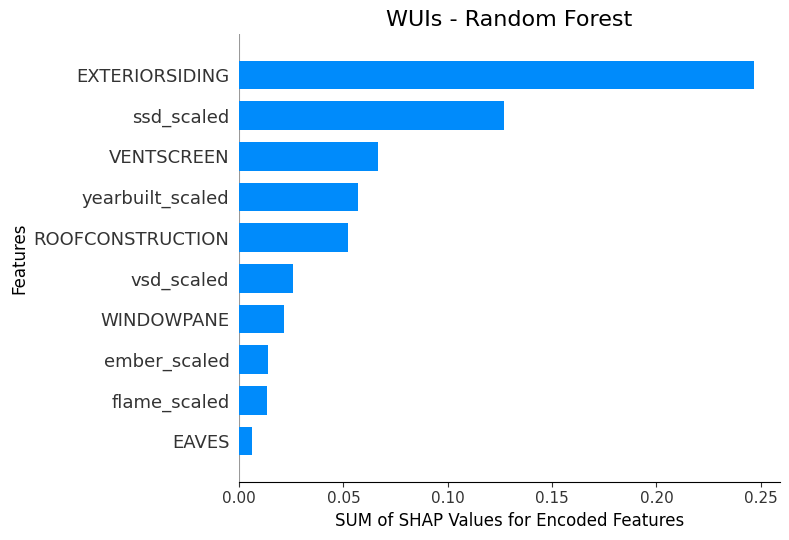

In [10]:
import os
import joblib
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

# Read datasets
with open("concatenated_df_ohe_targets_train_test_num_ready_data_binary.pkl", "rb") as file:
    data_dict = pickle.load(file)
    
# Load Random Forest model
with open("rf_v0_using_numeric_features.pkl", "rb") as file:
    model_rf = pickle.load(file)

# define X_test, y_test
X_test, y_test = data_dict["X_test"], data_dict["y_test"]
X_train, y_train = data_dict["X_train"], data_dict["y_train"]

# model_rf is RandomizedSearchCV object containing RandomForestClassifier
best_model = model_rf.best_estimator_

# Create a SHAP explainer using the best model
explainer_rf = shap.Explainer(best_model)

# Calculate SHAP values 
shap_values_rf = explainer_rf(X_test)

# Calculate the sum of SHAP values for each feature
sum_shap_values = np.sum(np.abs(shap_values_rf.values), axis=2)


# Create a DataFrame to store the sum of SHAP values
sum_shap_values_df = pd.DataFrame(sum_shap_values, columns=X_test.columns)

# Define the aggregate features
aggregate_features = {
    'ROOFCONSTRUCTION': ['Fire Resistant', 'Combustible','Asphalt', 'Concrete', 'Metal', 'Other', 'Tile', 'Wood'],
    'EAVES': ['Enclosed', 'No Eaves', 'Unenclosed', 'Not Applicable'],
    'VENTSCREEN': ['Mesh Screen <= 1/8"', 'Mesh Screen > 1/8"', 'No Vents', 'Unscreened', 'Screened'],
    'EXTERIORSIDING': ['Combustible','Stucco/Brick/Cement','Ignition Resistant','Vinyl', 'Stucco Brick Cement', 'Metal', 'Other', 'Wood', 'Fire Resistant'],
    'WINDOWPANE': ['Multi Pane', 'No Windows', 'Single Pane']
}


for feature in aggregate_features:
    categories = aggregate_features[feature]
    column_names = [f"{feature}_{category}" for category in categories]
    sum_shap_values_df[feature] = sum_shap_values_df[column_names].sum(axis=1, skipna=True)
    sum_shap_values_df.drop(columns=column_names, inplace=True)

# Create a SHAP summary plot with aggregated features
shap.summary_plot(sum_shap_values_df, feature_names=sum_shap_values_df.columns, plot_type="bar", show=False)
plt.title("WUIs - Random Forest", fontsize=16)
plt.xlabel("SUM of SHAP Values for Encoded Features", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.tight_layout()
plt.show()


## XGBoost

[19:34:17] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[19:34:20] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
100%|===================| 6860/6870 [08:05<00:00]        

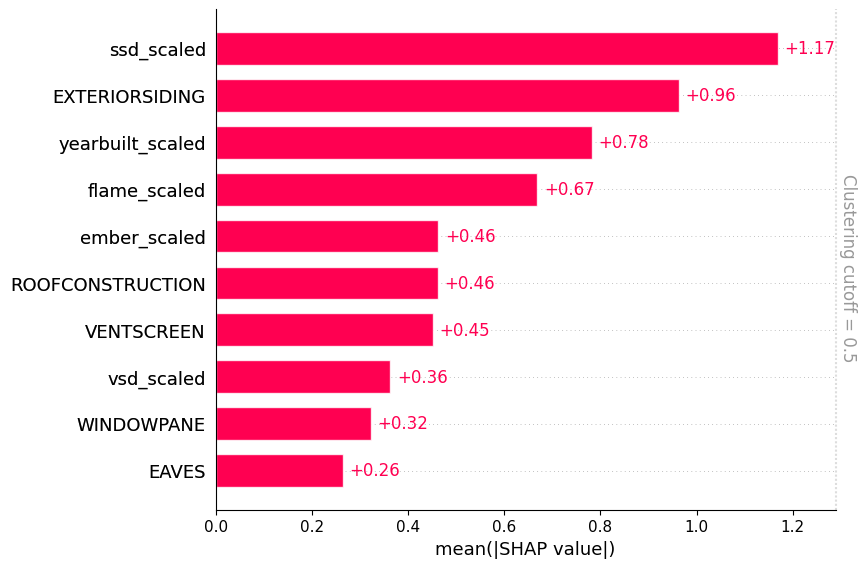

In [29]:
import os
import joblib
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

# Read datasets
with open("concatenated_df_ohe_targets_train_test_num_ready_data_binary.pkl", "rb") as file:
    data_dict = pickle.load(file)
    
# Load Random Forest model
with open("xgb_v0_using_numeric_features.pkl", "rb") as file:
    model_xgb = pickle.load(file)

#X_test = X_test.rename(columns={'VENTSCREEN_Mesh Screen <= 1/8"': 'VENTSCREEN_Mesh Screen lt= 1/8"'})
# Define X_test, y_test, X_train, y_train
X_test, y_test = data_dict["X_test"], data_dict["y_test"]
X_train, y_train = data_dict["X_train"], data_dict["y_train"]

def treat_encoded_shap_vals(sv, X, data_dict):
    shap_values = sv
    # reconstruct the original dataset before encoding
    X_cat_cols = data_dict["X_encoder"].get_feature_names_out().tolist()
    X_num_cols = ['yearbuilt_scaled', 'ssd_scaled', 'ember_scaled', 'flame_scaled', 'vsd_scaled'] 
    
    X_cat_original = data_dict["X_encoder"].inverse_transform(X[X_cat_cols])
    X_cat_original = pd.DataFrame(X_cat_original, columns=data_dict["X_encoder"].feature_names_in_)
    X_num_original = X.loc[:, X_num_cols].reset_index().drop(["index"], axis=1)
    X_original = X_cat_original.join(X_num_original)
    feature_names = X_cat_original.columns

    # get number of unique classes within each categorical data
    n_categories = []
    for f in feature_names[:-1]:
        n = X_cat_original[f].nunique()
        n_categories.append(n)

    # separating the shap values for categorical and numerical data
    # this part needs to be done according to the order of the 
    # features in axis=1.
    shap_values_cat = shap_values.values[:, :-len(X_num_cols)]
    shap_values_num = shap_values.values[:, -len(X_num_cols):]

    # replace the aggregated shap values for catgorical features
    new_shap_values_cat = []
    for values in shap_values_cat:        
        values_split = np.split(values , np.cumsum(n_categories))
        values_sum = [sum(vs) for vs in values_split]
        new_shap_values_cat.append(values_sum)
        
    new_shap_values_cat = np.array(new_shap_values_cat)
    new_shape_values = np.hstack((new_shap_values_cat, shap_values_num))
    shap_values.values = new_shape_values
    shap_values.data = X_original.values
    shap_values.feature_names = feature_names.to_list() + X_num_cols
    
    return shap_values, X_original 

# best model estimator
best_model_xgb = model_xgb.best_estimator_

# Create a SHAP explainer using the best model
explainer = shap.Explainer(best_model_xgb, masker=X_test)

# Calculate SHAP values 
shap_values_exp = explainer(X_test)
shap_values, X_test_original = treat_encoded_shap_vals(shap_values_exp, X_test, data_dict)

# Convert shap_values to numpy array
shap_values_array = shap_values.values

# Apply clustering to SHAP values using the 'euclidean' metric
clustering = shap.utils.hclust(shap_values_array, metric='euclidean')

# Get the feature order based on the clustering
feature_order = np.argsort(clustering.flatten())

# Create a SHAP bar plot with the filtered features
shap.plots.bar(shap_values, clustering=clustering, max_display=20)

## Testing by Fire

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier, DMatrix
from sklearn.preprocessing import LabelEncoder
import pickle
import shap
import xgboost as xgb
from sklearn.utils import shuffle
from utils.preprocessing import data_preprocessing_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score

# ML related imports
from xgboost import XGBClassifier, DMatrix
from sklearn.preprocessing import LabelEncoder
import pickle
import shap

fire_list = ["Tubbs", "Camp", "Glass", "Kincade", "Thomas"]
all_X_train = pd.DataFrame()
all_y_train = pd.DataFrame()
all_X_test = pd.DataFrame()
all_y_test = pd.DataFrame()
for i, case in enumerate(fire_list):
    data_dict = data_preprocessing_pipeline(case, 
                                            renew_data=True, 
                                            encode_data=False, 
                                            scale_data=True,
                                            task_type="binary")
    tmp_x_train = data_dict["X_train"]
    tmp_x_train["fire_id"] = i
    tmp_y_train = data_dict["y_train"]
    all_X_train = pd.concat([all_X_train, tmp_x_train], axis=0)
    all_y_train = pd.concat([all_y_train, tmp_y_train], axis=0)

    tmp_x_test = data_dict["X_test"]
    tmp_x_test["fire_id"] = i
    tmp_y_test = data_dict["y_test"]
    all_X_test = pd.concat([all_X_test, tmp_x_test], axis=0)
    all_y_test = pd.concat([all_y_test, tmp_y_test], axis=0)

all_X_train.drop("fire_id", axis=1, inplace=True)
all_X_train = shuffle(all_X_train)
all_y_train = shuffle(all_y_train)

all_X_test = shuffle(all_X_test)
all_X_test = shuffle(all_X_test)

# Assuming X_train contains the same columns as your dataset
categorical_columns = ['ROOFCONSTRUCTION', 'EAVES', 'VENTSCREEN', 'EXTERIORSIDING', 'WINDOWPANE']

# Encode categorical columns
label_encoders = {}
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    all_X_train[col] = label_encoders[col].fit_transform(all_X_train[col])
    all_X_test[col] = label_encoders[col].transform(all_X_test[col])
    
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_X_train, all_y_train, test_size=0.2, random_state=42)

# Train the XGBoost model
model = xgb.XGBClassifier(n_estimators=1000,
                          learning_rate=0.1,
                          max_depth=3,
                          subsample=0.9,
                          max_features="sqrt",
                          min_impurity_decrease=0,
                          ccp_alpha=0.01,
                          random_state=42)

model.fit(X_train, y_train.values.ravel())

# Define the explainer using the entire training dataset
explainer = shap.Explainer(model, X_train)

#test by fire
test_case = "Tubbs"
fire_id = 0
X_test = all_X_test.query("fire_id==0")
X_test.drop("fire_id", axis=1, inplace=True)

# Calculate SHAP values 
shap_values = explainer(X_test)

# Extract SHAP values from the Explanation object
shap_values_array = shap_values.values

# Apply hierarchical clustering to SHAP values
clustering = shap.utils.hclust(shap_values_array, metric='euclidean')

# Get the feature order based on the clustering
feature_order = np.argsort(clustering.flatten())

# Create a SHAP bar plot with clustering
shap.plots.bar(shap_values, clustering=clustering, max_display=20)


## Entire WUI Accuracy

In [13]:
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
import pandas as pd
import numpy as np
import pickle

# Read data_dict
with open("concatenated_df_ohe_targets_train_test_num_ready_data_binary.pkl", "rb") as file:
    data_dict = pickle.load(file)
    
# Load model
with open("xgb_v0_using_numeric_features.pkl", "rb") as file:
    model_xgb = pickle.load(file)
    
# define X_test, y_test
X_test, y_test = data_dict["X_test"], data_dict["y_test"]
X_train, y_train = data_dict["X_train"], data_dict["y_train"]
X_test = X_test.rename(columns={'VENTSCREEN_Mesh Screen <= 1/8"': 'VENTSCREEN_Mesh Screen lt= 1/8"'})

# Calculate TP, FP, TN, FN
TN_xgb, FP_xgb, FN_xgb, TP_xgb = confusion_matrix(y_test.values, model_xgb.predict(X_test)).ravel()

# Calculate AUC
auc_xgb = roc_auc_score(y_test.values, model_xgb.predict_proba(X_test)[:, 1])

# Calculate Accuracy
accuracy_xgb = accuracy_score(y_test.values, model_xgb.predict(X_test))

# Calculate recall/sensitivity
recall = TP_xgb / (TP_xgb + FN_xgb)

print("XGBoost Metrics:")
print(f"TP: {TP_xgb}, FP: {FP_xgb}, TN: {TN_xgb}, FN: {FN_xgb}")
print(f"AUC: {auc_xgb}")
print(f"Accuracy: {accuracy_xgb}")
print(f"Recall/Sensitivity: {recall}")

XGBoost Metrics:
TP: 4785, FP: 847, TN: 885, FN: 353
AUC: 0.8338196605107799
Accuracy: 0.8253275109170306
Recall/Sensitivity: 0.9312962242117555


## Change features (Hardening, Defensible Space, ...)

#### Home Hardening Scenario

Confusion Matrix:
[[ 769  963]
 [ 234 4904]]
ROC AUC Score: 0.8183635696351147
Accuracy Score: 0.825764192139738
XGBoost Metrics:
TP: 4904, FP: 963, TN: 769, FN: 234
AUC: 0.8183635696351147
Accuracy: 0.825764192139738
Recall/Sensitivity: 0.9544569871545349


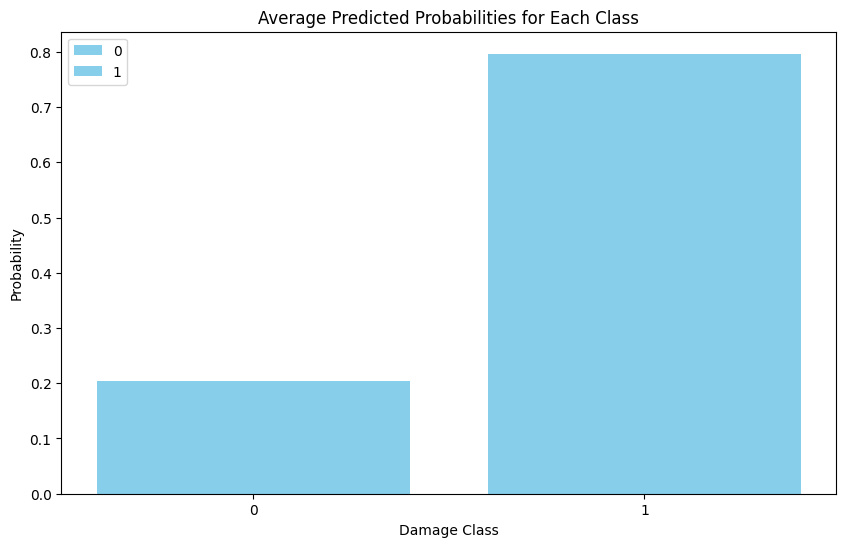

In [1]:
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import pickle
import xgboost as xgb
import matplotlib.pyplot as plt

with open("concatenated_df_ohe_targets_train_test_cat_ready_data_binary.pkl", "rb") as file:
    data_dict = pickle.load(file)

# Define the replacements for building features
replacements = {
    'EAVES': {'Unenclosed': 'Enclosed'},
    'EXTERIORSIDING': {'Combustibe': 'Ignition Resistant', 'Wood': 'Stucco Brick Cement', 'Vinyl': 'Metal'},
    'VENTSCREEN': {'No Vents': 'Mesh Screen <= 1/8"', 'Unscreened': 'Mesh Screen <= 1/8"', 'Screened': 'Mesh Screen <= 1/8"','Mesh Screen > 1/8"': 'Mesh Screen <= 1/8"'},
    'ROOFCONSTRUCTION': {'Combustible': 'Fire Resistant', 'Tile': 'Metal', 'Wood': 'Metal', 'Asphalt': 'Fire Resistant'},
    'WINDOWPANE': {'Single Pane': 'Multi Pane'}
}

# Apply the replacements
for col, rep in replacements.items():
    if col in data_dict['X_test']:
        data_dict['X_test'][col] = data_dict['X_test'][col].replace(rep)

# Save the modified dataset back to a new pickle file
with open("concatenated_df_ohe_targets_train_test_cat_ready_data_binary_modified.pkl", "wb") as file:
    pickle.dump(data_dict, file)

# Assuming X_train contains the same columns as your dataset
categorical_columns = ['ROOFCONSTRUCTION', 'EAVES', 'VENTSCREEN', 'EXTERIORSIDING', 'WINDOWPANE']

# Encode categorical columns
label_encoders = {}
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    data_dict['X_train'][col] = label_encoders[col].fit_transform(data_dict['X_train'][col])
    data_dict['X_test'][col] = label_encoders[col].transform(data_dict['X_test'][col])

# Convert object columns to category dtype
object_cols = data_dict['X_train'].select_dtypes(include=['object']).columns
data_dict['X_train'][object_cols] = data_dict['X_train'][object_cols].astype('category')
data_dict['X_test'][object_cols] = data_dict['X_test'][object_cols].astype('category')


# Define X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = data_dict['X_train'], data_dict['X_test'], data_dict['y_train'], data_dict['y_test']

# Train the XGBoost model with categorical support
model = xgb.XGBClassifier(n_estimators=1000,
                          learning_rate=0.1,
                          max_depth=3,
                          subsample=0.9,
                          random_state=42,
                          enable_categorical=True)

model.fit(X_train, y_train.values.ravel())


# Make predictions using the trained XGBoost model
y_pred = model.predict(X_test)

# Convert y_test to a numpy array and ensure it has the same dtype as y_pred
y_test = np.array(y_test).astype(y_pred.dtype)

# Calculate evaluation metrics
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
accuracy = accuracy_score(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("ROC AUC Score:", roc_auc)
print("Accuracy Score:", accuracy)

# Calculate TP, FP, TN, FN
TN_xgb, FP_xgb, FN_xgb, TP_xgb = confusion_matrix(y_test, y_pred).ravel()

# Calculate AUC
auc_xgb = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

# Calculate Accuracy
accuracy_xgb = accuracy_score(y_test, y_pred)

# Calculate recall/sensitivity
recall = TP_xgb / (TP_xgb + FN_xgb)

print("XGBoost Metrics:")
print(f"TP: {TP_xgb}, FP: {FP_xgb}, TN: {TN_xgb}, FN: {FN_xgb}")
print(f"AUC: {auc_xgb}")
print(f"Accuracy: {accuracy_xgb}")
print(f"Recall/Sensitivity: {recall}")

# Get the predicted probabilities for each class
y_prob = model.predict_proba(X_test)

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(model.classes_)), y_prob.mean(axis=0), color='skyblue')

# Add labels, title, and legend
plt.xlabel('Damage Class')
plt.ylabel('Probability')
plt.title('Average Predicted Probabilities for Each Class')
plt.xticks(range(len(model.classes_)), model.classes_)
plt.legend(bars, model.classes_)

# Show plot
plt.show()



#### All Bulding Features without VSD

Confusion Matrix:
[[ 737  995]
 [ 223 4915]]
ROC AUC Score: 0.8140632065387904
Accuracy Score: 0.8227074235807861
XGBoost Metrics:
TP: 4915, FP: 995, TN: 737, FN: 223
AUC: 0.8140632065387904
Accuracy: 0.8227074235807861
Recall/Sensitivity: 0.9565978980147918


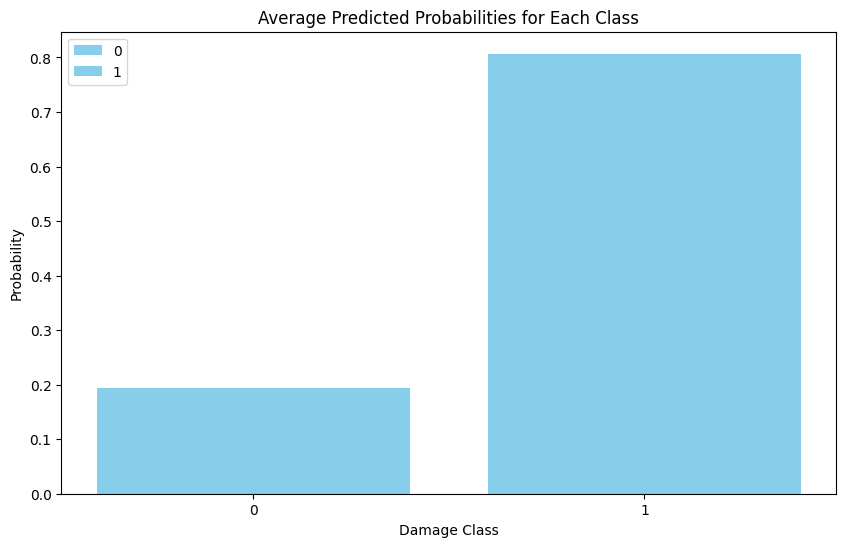

In [1]:
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import pickle
import xgboost as xgb
import matplotlib.pyplot as plt

with open("concatenated_df_ohe_targets_train_test_cat_ready_data_binary.pkl", "rb") as file:
    data_dict = pickle.load(file)

# Define the replacements for building features
replacements = {
    'EAVES': {'Unenclosed': 'Enclosed'},
    'EXTERIORSIDING': {'Combustibe': 'Ignition Resistant', 'Wood': 'Stucco Brick Cement', 'Vinyl': 'Metal'},
    'VENTSCREEN': {'No Vents': 'Mesh Screen <= 1/8"', 'Unscreened': 'Mesh Screen <= 1/8"', 'Screened': 'Mesh Screen <= 1/8"','Mesh Screen > 1/8"': 'Mesh Screen <= 1/8"'},
    'ROOFCONSTRUCTION': {'Combustible': 'Fire Resistant', 'Tile': 'Metal', 'Wood': 'Metal', 'Asphalt': 'Concrete'},
    'WINDOWPANE': {'Single Pane': 'Multi Pane'}
}

# Apply the replacements
for col, rep in replacements.items():
    if col in data_dict['X_test']:
        data_dict['X_test'][col] = data_dict['X_test'][col].replace(rep)

# Save the modified dataset back to a new pickle file
with open("concatenated_df_ohe_targets_train_test_cat_ready_data_binary_modified.pkl", "wb") as file:
    pickle.dump(data_dict, file)

# Assuming X_train contains the same columns as your dataset
categorical_columns = ['ROOFCONSTRUCTION', 'EAVES', 'VENTSCREEN', 'EXTERIORSIDING', 'WINDOWPANE']

# Encode categorical columns
label_encoders = {}
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    data_dict['X_train'][col] = label_encoders[col].fit_transform(data_dict['X_train'][col])
    data_dict['X_test'][col] = label_encoders[col].transform(data_dict['X_test'][col])

# Convert object columns to category dtype
object_cols = data_dict['X_train'].select_dtypes(include=['object']).columns
data_dict['X_train'][object_cols] = data_dict['X_train'][object_cols].astype('category')
data_dict['X_test'][object_cols] = data_dict['X_test'][object_cols].astype('category')


# Define X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = data_dict['X_train'], data_dict['X_test'], data_dict['y_train'], data_dict['y_test']

# Train the XGBoost model with categorical support
model = xgb.XGBClassifier(n_estimators=1000,
                          learning_rate=0.1,
                          max_depth=3,
                          subsample=0.9,
                          random_state=42,
                          enable_categorical=True)

model.fit(X_train, y_train.values.ravel())


# Make predictions using the trained XGBoost model
y_pred = model.predict(X_test)

# Convert y_test to a numpy array and ensure it has the same dtype as y_pred
y_test = np.array(y_test).astype(y_pred.dtype)

# Calculate evaluation metrics
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
accuracy = accuracy_score(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("ROC AUC Score:", roc_auc)
print("Accuracy Score:", accuracy)

# Calculate TP, FP, TN, FN
TN_xgb, FP_xgb, FN_xgb, TP_xgb = confusion_matrix(y_test, y_pred).ravel()

# Calculate AUC
auc_xgb = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

# Calculate Accuracy
accuracy_xgb = accuracy_score(y_test, y_pred)

# Calculate recall/sensitivity
recall = TP_xgb / (TP_xgb + FN_xgb)

print("XGBoost Metrics:")
print(f"TP: {TP_xgb}, FP: {FP_xgb}, TN: {TN_xgb}, FN: {FN_xgb}")
print(f"AUC: {auc_xgb}")
print(f"Accuracy: {accuracy_xgb}")
print(f"Recall/Sensitivity: {recall}")

# Get the predicted probabilities for each class
y_prob = model.predict_proba(X_test)

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(model.classes_)), y_prob.mean(axis=0), color='skyblue')

# Add labels, title, and legend
plt.xlabel('Damage Class')
plt.ylabel('Probability')
plt.title('Average Predicted Probabilities for Each Class')
plt.xticks(range(len(model.classes_)), model.classes_)
plt.legend(bars, model.classes_)

# Show plot
plt.show()


### All Building Features with VSD

Confusion Matrix:
[[1055  677]
 [1390 3748]]
ROC AUC Score: 0.7269737463108281
Accuracy Score: 0.6991266375545852
XGBoost Metrics:
TP: 3748, FP: 677, TN: 1055, FN: 1390
AUC: 0.7269737463108281
Accuracy: 0.6991266375545852
Recall/Sensitivity: 0.729466718567536


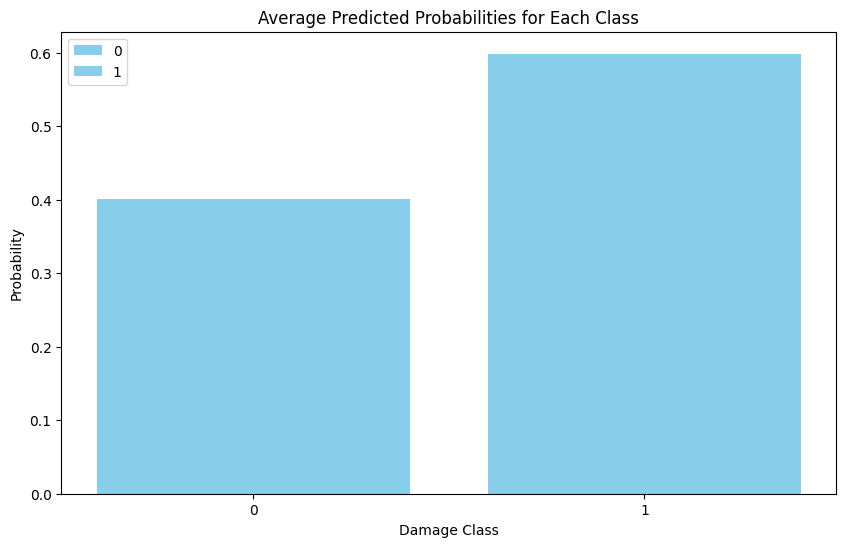

In [5]:
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import pickle
import xgboost as xgb
import matplotlib.pyplot as plt

# Read data_dict
with open("concatenated_df_ohe_targets_train_test_cat_ready_data_binary_DS.pkl", "rb") as file:
    data_dict = pickle.load(file)
    
# Round down the 'VSD' column
data_dict['X_test']['VSD'] = data_dict['X_test']['VSD'].apply(lambda x: 0 if x < 1 else (2 if x > 2 else 1))

# Replace 0 with 3
data_dict['X_test']['VSD'] = data_dict['X_test']['VSD'].replace(0, 3)


# Define the replacements for building features
replacements = {
    'EAVES': {'Unenclosed': 'Enclosed'},
    'EXTERIORSIDING': {'Combustibe': 'Ignition Resistant', 'Wood': 'Stucco Brick Cement', 'Vinyl': 'Metal'},
    'VENTSCREEN': {'No Vents': 'Mesh Screen <= 1/8"', 'Unscreened': 'Mesh Screen <= 1/8"', 'Screened': 'Mesh Screen <= 1/8"','Mesh Screen > 1/8"': 'Mesh Screen <= 1/8"'},
    'ROOFCONSTRUCTION': {'Combustible': 'Fire Resistant', 'Tile': 'Metal', 'Wood': 'Metal', 'Asphalt': 'Concrete'},
    'WINDOWPANE': {'Single Pane': 'Multi Pane'}
}

# Apply the replacements
for col, rep in replacements.items():
    if col in data_dict['X_test']:
        data_dict['X_test'][col] = data_dict['X_test'][col].replace(rep)

# Save the modified dataset back to a new pickle file
with open("concatenated_df_ohe_targets_train_test_cat_ready_data_binary_modified.pkl", "wb") as file:
    pickle.dump(data_dict, file)

# Assuming X_train contains the same columns as your dataset
categorical_columns = ['ROOFCONSTRUCTION', 'EAVES', 'VENTSCREEN', 'EXTERIORSIDING', 'WINDOWPANE']

# Encode categorical columns
label_encoders = {}
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    data_dict['X_train'][col] = label_encoders[col].fit_transform(data_dict['X_train'][col])
    data_dict['X_test'][col] = label_encoders[col].transform(data_dict['X_test'][col])

# Convert object columns to category dtype
object_cols = data_dict['X_train'].select_dtypes(include=['object']).columns
data_dict['X_train'][object_cols] = data_dict['X_train'][object_cols].astype('category')
data_dict['X_test'][object_cols] = data_dict['X_test'][object_cols].astype('category')


# Define X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = data_dict['X_train'], data_dict['X_test'], data_dict['y_train'], data_dict['y_test']

# Train the XGBoost model with categorical support
model = xgb.XGBClassifier(n_estimators=1000,
                          learning_rate=0.1,
                          max_depth=3,
                          subsample=0.9,
                          random_state=42,
                          enable_categorical=True)

model.fit(X_train, y_train.values.ravel())


# Make predictions using the trained XGBoost model
y_pred = model.predict(X_test)

# Convert y_test to a numpy array and ensure it has the same dtype as y_pred
y_test = np.array(y_test).astype(y_pred.dtype)

# Calculate evaluation metrics
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
accuracy = accuracy_score(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("ROC AUC Score:", roc_auc)
print("Accuracy Score:", accuracy)

# Calculate TP, FP, TN, FN
TN_xgb, FP_xgb, FN_xgb, TP_xgb = confusion_matrix(y_test, y_pred).ravel()

# Calculate AUC
auc_xgb = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

# Calculate Accuracy
accuracy_xgb = accuracy_score(y_test, y_pred)

# Calculate recall/sensitivity
recall = TP_xgb / (TP_xgb + FN_xgb)

print("XGBoost Metrics:")
print(f"TP: {TP_xgb}, FP: {FP_xgb}, TN: {TN_xgb}, FN: {FN_xgb}")
print(f"AUC: {auc_xgb}")
print(f"Accuracy: {accuracy_xgb}")
print(f"Recall/Sensitivity: {recall}")

# Get the predicted probabilities for each class
y_prob = model.predict_proba(X_test)

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(model.classes_)), y_prob.mean(axis=0), color='skyblue')

# Add labels, title, and legend
plt.xlabel('Damage Class')
plt.ylabel('Probability')
plt.title('Average Predicted Probabilities for Each Class')
plt.xticks(range(len(model.classes_)), model.classes_)
plt.legend(bars, model.classes_)

# Show plot
plt.show()


## Other VSD Changes

Confusion Matrix:
[[1322  410]
 [1718 3420]]
ROC AUC Score: 0.793132802548057
Accuracy Score: 0.6902474526928676
XGBoost Metrics:
TP: 3420, FP: 410, TN: 1322, FN: 1718
AUC: 0.793132802548057
Accuracy: 0.6902474526928676
Recall/Sensitivity: 0.6656286492798754


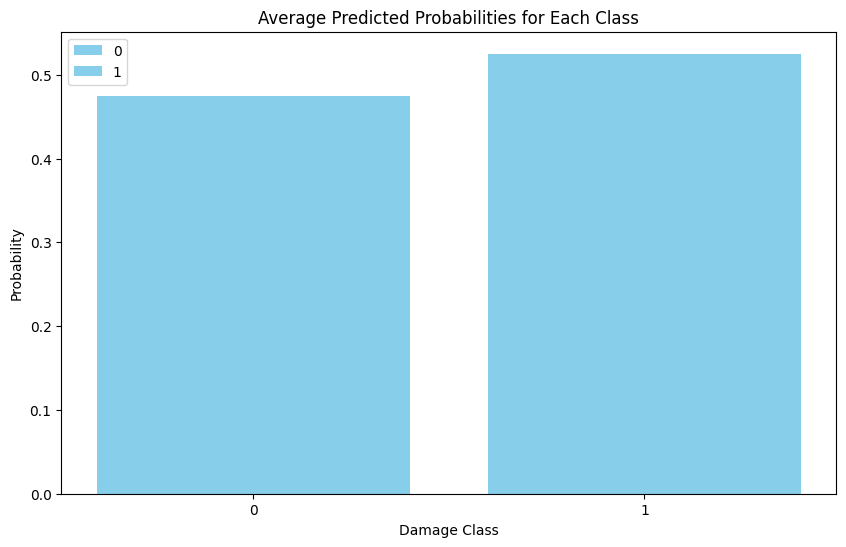

In [8]:
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import pickle
import xgboost as xgb
import matplotlib.pyplot as plt

# Read data_dict
with open("concatenated_df_ohe_targets_train_test_cat_ready_data_binary_DS.pkl", "rb") as file:
    data_dict = pickle.load(file)
    
# Round down the 'VSD' column
data_dict['X_test']['VSD'] = data_dict['X_test']['VSD'].apply(lambda x: 0 if x < 1 else (2 if x > 2 else 1))

# Replace Zone 0 with Zone 1
# Replace 0 and 1 with 2
data_dict['X_test']['VSD'] = data_dict['X_test']['VSD'].replace([0, 1], 3)



# Define the replacements for building features
replacements = {
    'EAVES': {'Unenclosed': 'Enclosed'},
    'EXTERIORSIDING': {'Combustibe': 'Ignition Resistant', 'Wood': 'Stucco Brick Cement', 'Vinyl': 'Metal'},
    'VENTSCREEN': {'No Vents': 'Mesh Screen <= 1/8"', 'Unscreened': 'Mesh Screen <= 1/8"', 'Screened': 'Mesh Screen <= 1/8"','Mesh Screen > 1/8"': 'Mesh Screen <= 1/8"'},
    'ROOFCONSTRUCTION': {'Combustible': 'Fire Resistant', 'Tile': 'Metal', 'Wood': 'Metal', 'Asphalt': 'Concrete'},
    'WINDOWPANE': {'Single Pane': 'Multi Pane'}
}

# Apply the replacements
for col, rep in replacements.items():
    if col in data_dict['X_test']:
        data_dict['X_test'][col] = data_dict['X_test'][col].replace(rep)

# Save the modified dataset back to a new pickle file
with open("concatenated_df_ohe_targets_train_test_cat_ready_data_binary_modified.pkl", "wb") as file:
    pickle.dump(data_dict, file)

# Assuming X_train contains the same columns as your dataset
categorical_columns = ['ROOFCONSTRUCTION', 'EAVES', 'VENTSCREEN', 'EXTERIORSIDING', 'WINDOWPANE']

# Encode categorical columns
label_encoders = {}
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    data_dict['X_train'][col] = label_encoders[col].fit_transform(data_dict['X_train'][col])
    data_dict['X_test'][col] = label_encoders[col].transform(data_dict['X_test'][col])

# Convert object columns to category dtype
object_cols = data_dict['X_train'].select_dtypes(include=['object']).columns
data_dict['X_train'][object_cols] = data_dict['X_train'][object_cols].astype('category')
data_dict['X_test'][object_cols] = data_dict['X_test'][object_cols].astype('category')


# Define X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = data_dict['X_train'], data_dict['X_test'], data_dict['y_train'], data_dict['y_test']

# Train the XGBoost model with categorical support
model = xgb.XGBClassifier(n_estimators=1000,
                          learning_rate=0.1,
                          max_depth=3,
                          subsample=0.9,
                          random_state=42,
                          enable_categorical=True)

model.fit(X_train, y_train.values.ravel())


# Make predictions using the trained XGBoost model
y_pred = model.predict(X_test)

# Convert y_test to a numpy array and ensure it has the same dtype as y_pred
y_test = np.array(y_test).astype(y_pred.dtype)

# Calculate evaluation metrics
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
accuracy = accuracy_score(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("ROC AUC Score:", roc_auc)
print("Accuracy Score:", accuracy)

# Calculate TP, FP, TN, FN
TN_xgb, FP_xgb, FN_xgb, TP_xgb = confusion_matrix(y_test, y_pred).ravel()

# Calculate AUC
auc_xgb = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

# Calculate Accuracy
accuracy_xgb = accuracy_score(y_test, y_pred)

# Calculate recall/sensitivity
recall = TP_xgb / (TP_xgb + FN_xgb)

print("XGBoost Metrics:")
print(f"TP: {TP_xgb}, FP: {FP_xgb}, TN: {TN_xgb}, FN: {FN_xgb}")
print(f"AUC: {auc_xgb}")
print(f"Accuracy: {accuracy_xgb}")
print(f"Recall/Sensitivity: {recall}")

# Get the predicted probabilities for each class
y_prob = model.predict_proba(X_test)

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(model.classes_)), y_prob.mean(axis=0), color='skyblue')

# Add labels, title, and legend
plt.xlabel('Damage Class')
plt.ylabel('Probability')
plt.title('Average Predicted Probabilities for Each Class')
plt.xticks(range(len(model.classes_)), model.classes_)
plt.legend(bars, model.classes_)

# Show plot
plt.show()


## PDF Analysis for flame and ember

/home/maryamz/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/maryamz/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/maryamz/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/maryamz/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf va

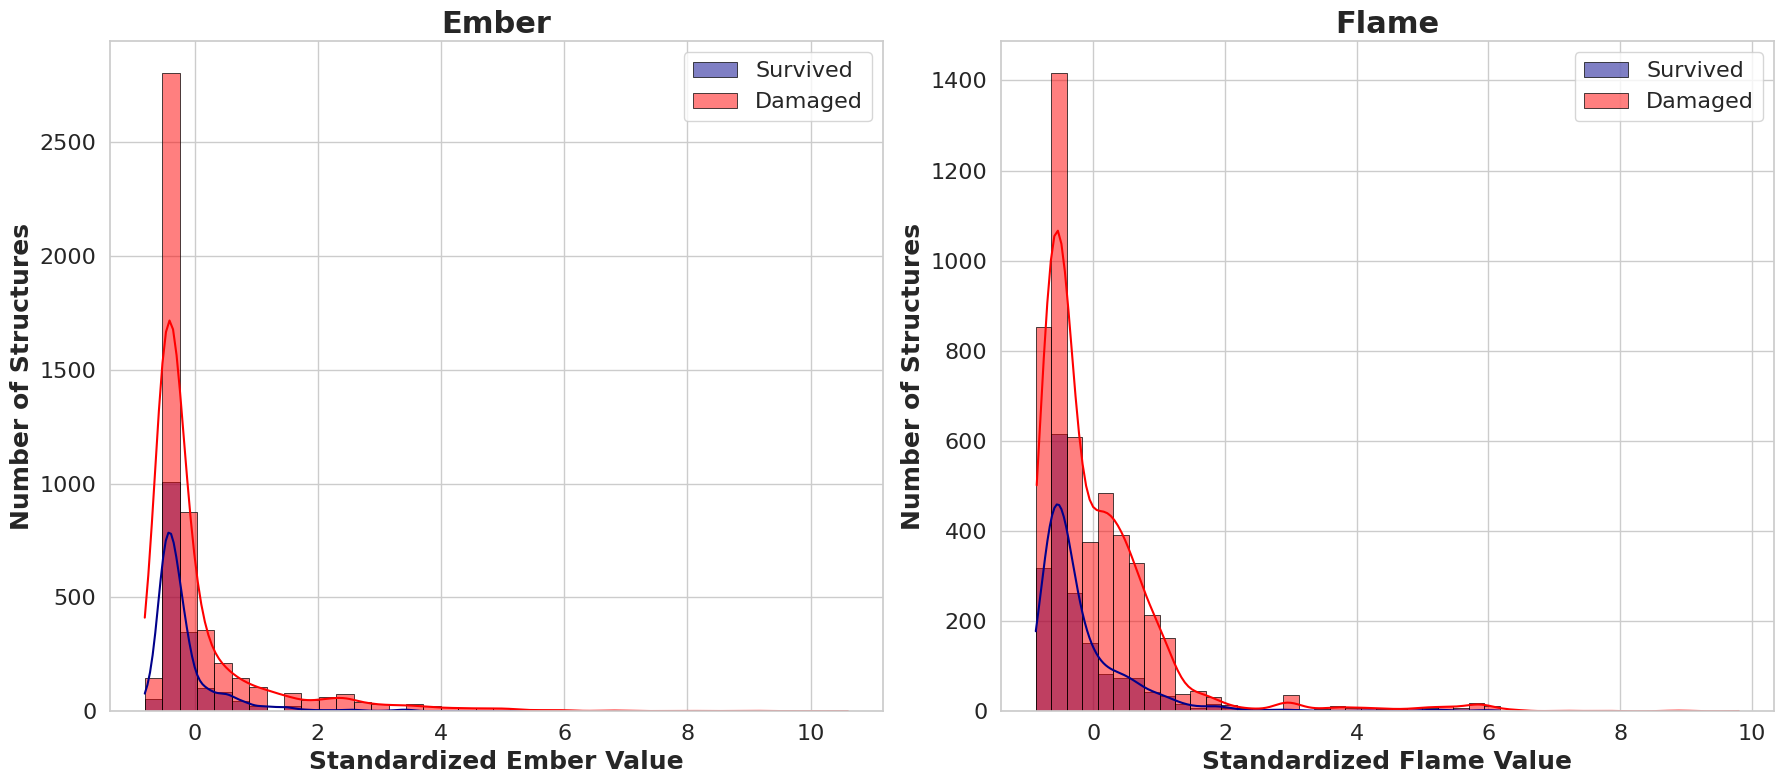

Script completed. Histograms of ember count and flame length distributions have been plotted.


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = '/home/maryamz/DINS_data_preparation/data_dict.csv'
df = pd.read_csv(file_path)

# Separate the data into survived and damaged structures
survived_structures = df[df['DAMAGE'] == 0]
damaged_structures = df[df['DAMAGE'] == 1]

# Set the style for the plots
sns.set(style="whitegrid")

# Create a figure with one row and two columns for histograms
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# Define the number of bins
num_bins = 30

# Create the bins based on the min and max values of both datasets for consistency
ember_bins = np.linspace(survived_structures['ember_scaled'].min(), survived_structures['ember_scaled'].max(), num_bins + 1)
flame_bins = np.linspace(survived_structures['flame_scaled'].min(), survived_structures['flame_scaled'].max(), num_bins + 1)

# Plot 1: Ember Count - Histogram
sns.histplot(survived_structures['ember_scaled'], ax=axs[0], bins=ember_bins, color='darkblue', kde=True, 
             alpha=0.5, label='Survived', edgecolor='black', linewidth=0.5)
sns.histplot(damaged_structures['ember_scaled'], ax=axs[0], bins=ember_bins, color='red', kde=True, 
             alpha=0.5, label='Damaged', edgecolor='black', linewidth=0.5)
axs[0].set_title('Ember', fontsize=22, fontweight='bold')
axs[0].set_xlabel('Standardized Ember Value', fontsize=18, fontweight='bold')
axs[0].set_ylabel('Number of Structures', fontsize=18, fontweight='bold')
axs[0].legend(fontsize=16)

# Set tick parameters for axes
axs[0].tick_params(axis='both', labelsize=16, width=2)

# Plot 2: Flame Length - Histogram
sns.histplot(survived_structures['flame_scaled'], ax=axs[1], bins=flame_bins, color='darkblue', kde=True, 
             alpha=0.5, label='Survived', edgecolor='black', linewidth=0.5)
sns.histplot(damaged_structures['flame_scaled'], ax=axs[1], bins=flame_bins, color='red', kde=True, 
             alpha=0.5, label='Damaged', edgecolor='black', linewidth=0.5)
axs[1].set_title('Flame', fontsize=22, fontweight='bold')
axs[1].set_xlabel('Standardized Flame Value', fontsize=18, fontweight='bold')
axs[1].set_ylabel('Number of Structures', fontsize=18, fontweight='bold')
axs[1].legend(fontsize=16)

# Set tick parameters for axes
axs[1].tick_params(axis='both', labelsize=16, width=2)

# Adjust layout
plt.tight_layout()
plt.show()

print("Script completed. Histograms of ember count and flame length distributions have been plotted.")


### Violin Plot

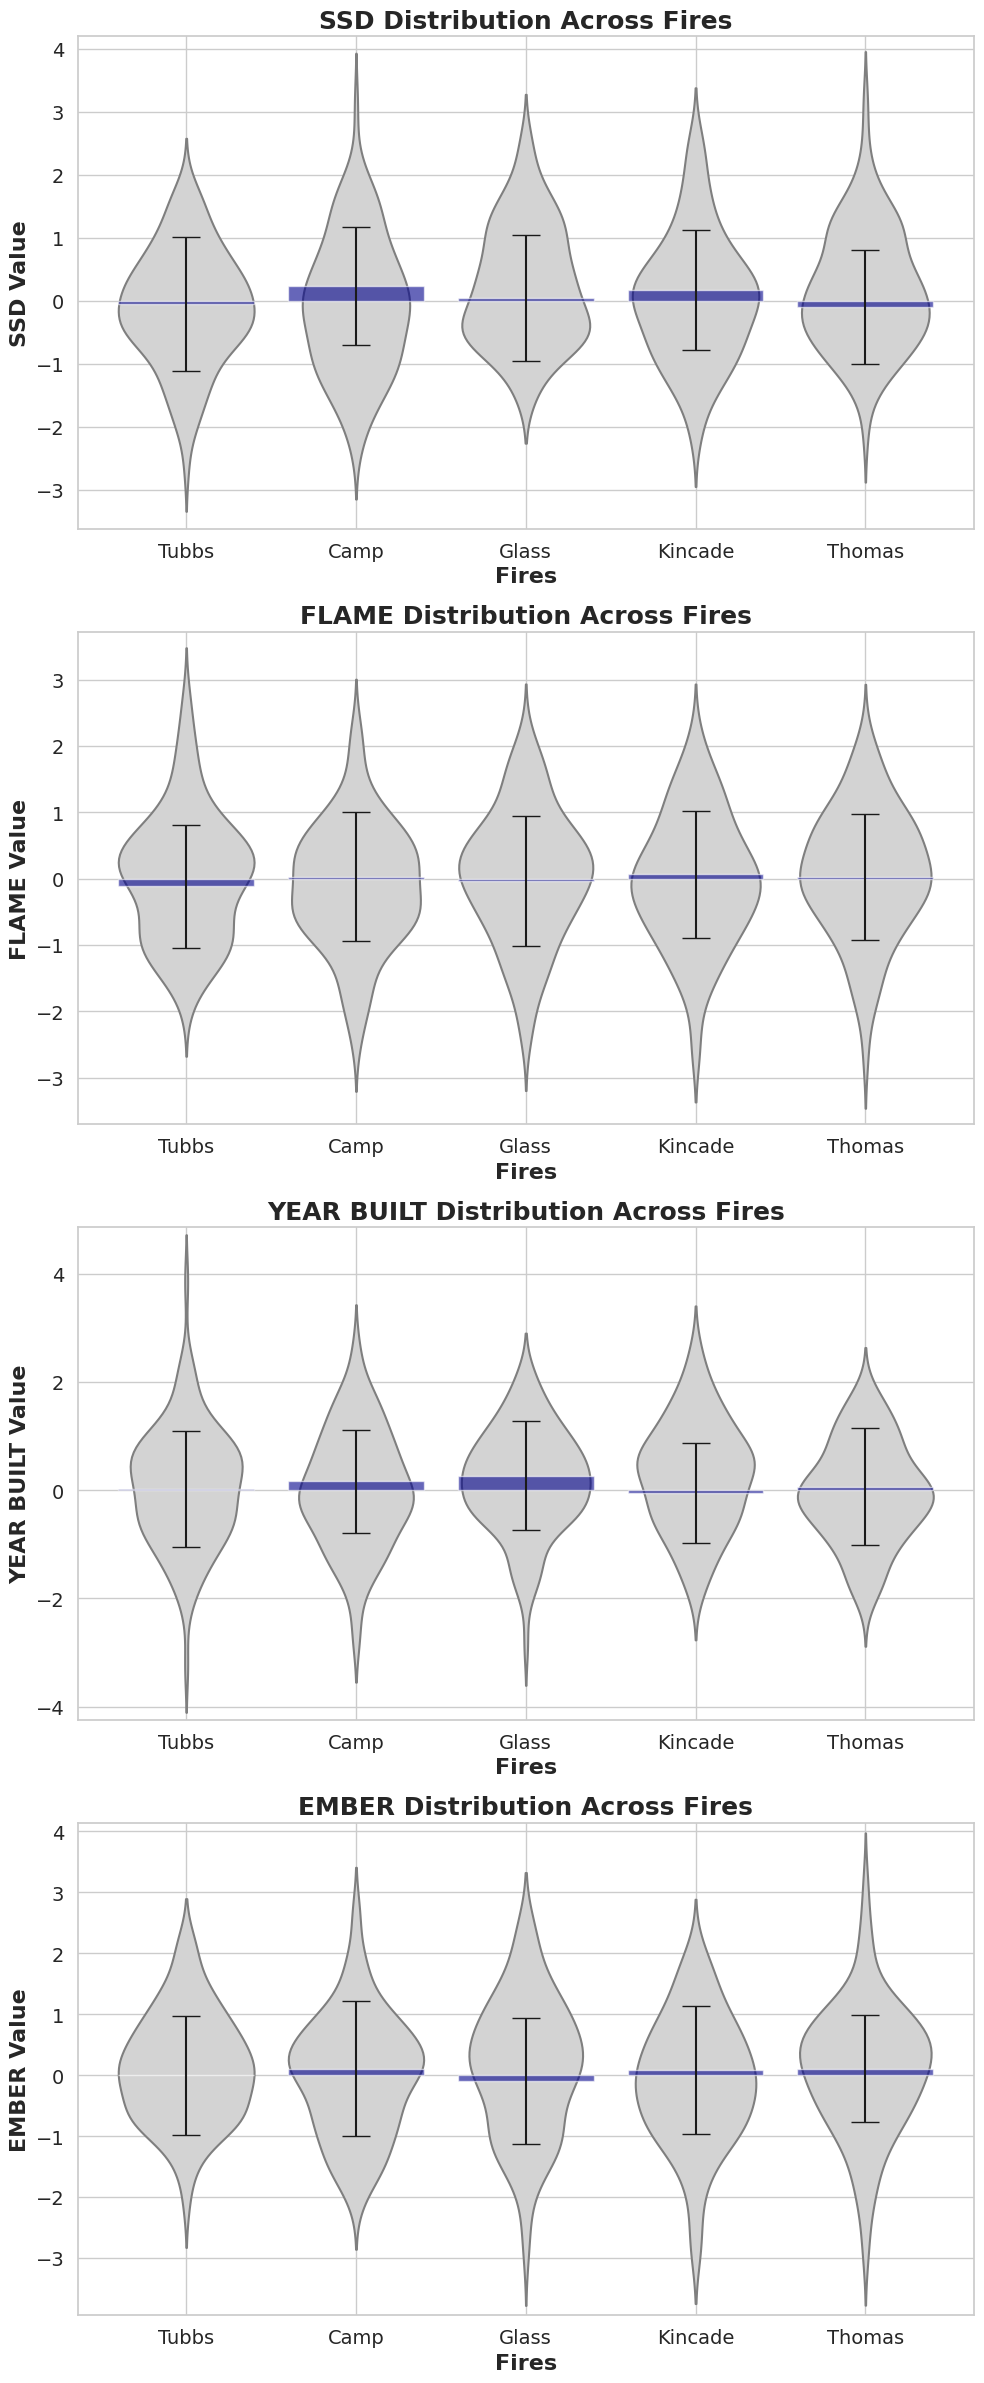

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap

# Example mock data for demonstration
fires = ["Tubbs", "Camp", "Glass", "Kincade", "Thomas"]
features = ["SSD", "FLAME", "YEAR BUILT", "EMBER"]

# Mock SHAP values or feature values for each fire 
np.random.seed(42)
data_dict = {fire: {feature: np.random.randn(100) for feature in features} for fire in fires}

# Convert the mock data into a DataFrame for easier handling
fire_df = pd.concat([pd.DataFrame(data_dict[fire]).assign(Fire=fire) for fire in fires])

# Start plotting: create combined violin and bar plot for each feature
fig, axs = plt.subplots(len(features), 1, figsize=(10, len(features) * 6))

for i, feature in enumerate(features):
    ax = axs[i]

    # Violin plot for feature across fires
    sns.violinplot(x='Fire', y=feature, data=fire_df, ax=ax, inner=None, color='lightgray')
    
    # Overlay a bar plot with mean and standard deviation
    mean_values = fire_df.groupby('Fire')[feature].mean()
    std_values = fire_df.groupby('Fire')[feature].std()
    
    ax.bar(fires, mean_values, yerr=std_values, color='darkblue', alpha=0.6, capsize=10)
    
    # Customize the plot with increased font sizes and bold text
    ax.set_title(f'{feature} Distribution Across Fires', fontsize=18, fontweight='bold')
    ax.set_ylabel(f'{feature} Value', fontsize=16, fontweight='bold')
    ax.set_xlabel('Fires', fontsize=16, fontweight='bold')
    ax.grid(True)

    # Set y-axis limits based on the data to allow visibility of variations
    ax.set_ylim(fire_df[feature].min() - 1, fire_df[feature].max() + 1)  

# Increase font size for ticks
for ax in axs:
    ax.tick_params(axis='both', labelsize=14, width=2)  

plt.tight_layout()
plt.show()


## Mitigation Scenario

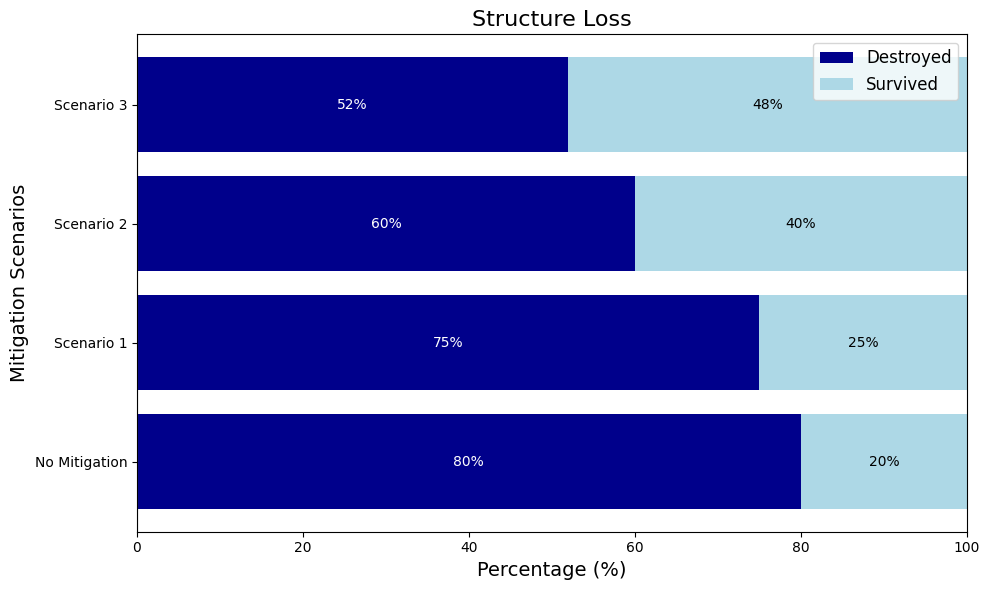

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Create the data
data = {
    'Scenario': ['No Mitigation', 'Scenario 1', 'Scenario 2', 'Scenario 3'],
    'Destroyed': [80, 75, 60, 52],
    'Survived': [20, 25, 40, 48]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Calculate the total for each scenario
df['Total'] = df['Destroyed'] + df['Survived']

# Calculate percentages
df['Destroyed %'] = df['Destroyed'] / df['Total'] * 100
df['Survived %'] = df['Survived'] / df['Total'] * 100

# Plot
plt.figure(figsize=(10, 6))

# Create horizontal bars for Destroyed and Survived
plt.barh(df['Scenario'], df['Destroyed %'], color='darkblue', label='Destroyed')
plt.barh(df['Scenario'], df['Survived %'], left=df['Destroyed %'], color='lightblue', label='Survived')

# Add data labels to the bars
for index, row in df.iterrows():
    plt.text(row['Destroyed %'] / 2, index, f"{int(row['Destroyed %'])}%", 
             ha='center', va='center', color='white', fontsize=10)
    plt.text(row['Destroyed %'] + row['Survived %'] / 2, index, f"{int(row['Survived %'])}%", 
             ha='center', va='center', color='black', fontsize=10)

# Labeling
plt.ylabel('Mitigation Scenarios', fontsize=14)
plt.xlabel('Percentage (%)', fontsize=14)
plt.title('Structure Loss', fontsize=16)
plt.xlim(0, 100)
plt.axvline(0, color='grey', linewidth=0.8)
plt.legend(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


### Sensitivity Analysis

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
import pickle
import xgboost as xgb
from sklearn.model_selection import train_test_split
import seaborn as sns
# --------------------------
# 1. Load full dataset and full model
# --------------------------
df = pd.read_pickle("concatenated_df_ohe_targets_train_test_num_ready_data_binary.pkl")
if isinstance(df, dict):
    if 'X_train' in df and 'y_train' in df:
        X_full = df['X_train'].copy()
        y = df['y_train']
    elif 'X_test' in df and 'y_test' in df:
        X_full = df['X_test'].copy()
        y = df['y_test']
    else:
        raise ValueError("Pickle data dict does not contain expected keys.")
else:
    X_full = df.drop(columns=['target'])
    y = df['target']

with open("xgb_v0_using_numeric_features.pkl", "rb") as f:
    full_model = pickle.load(f)

# --------------------------
# 2. Split into training and test sets (use test for sensitivity analysis)
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42)
baseline_test = X_test.copy()  # full-feature test set

# --------------------------
# 3. Define directories for ensemble TIFF files for each fire.
#    Here we assume separate directories for ember and flame ensembles.
# --------------------------
ember_dirs = {
    "Tubbs": "/path/to/file/Tubbs/EMBER/",
    "Thomas": "/path/to/file//Thomas/EMBER/",
    "Camp": "/path/to/file//Camp/EMBER/",
    "Kincade": "/path/to/file//Kincade/EMBER/",
    "Glass": "/path/to/file//Glass/EMBER/"
}
flame_dirs = {
    "Tubbs": "/path/to/file//Tubbs/FLAME_EN/",
    "Thomas": "/path/to/file//Thomas/FLAME_EN/",
    "Camp": "/path/to/file//Camp/FLAME_EN/",
    "Kincade": "/path/to/file//Kincade/FLAME_EN/",
    "Glass": "/path/to/file//Glass/FLAME_EN/"
}

# --------------------------
# 4. Sensitivity analysis for ember: vary only "ember_scaled"
# --------------------------
ember_results = {}
for fire, directory in ember_dirs.items():
    ensemble_files = glob.glob(os.path.join(directory, "*.tif"))
    ensemble_preds = []  # predictions for each ensemble file
    for file in ensemble_files:
        with rasterio.open(file) as src:
            raster_data = src.read(1).astype(float)
            nodata_value = src.nodata if src.nodata is not None else -9999
            raster_data[raster_data == nodata_value] = np.nan
            aggregated_value = np.nanmean(raster_data)
        test_modified = baseline_test.copy()
        test_modified["ember_scaled"] = aggregated_value
        # Ensure column names match training (if needed)
        test_modified.columns = [col.replace("<= 1/8", "lt= 1/8") for col in test_modified.columns]
        preds = full_model.predict(test_modified)
        ensemble_preds.append(preds)
    ensemble_preds = np.array(ensemble_preds)  # shape: (n_ensembles, n_samples)
    pred_mean = ensemble_preds.mean(axis=0)
    pred_std = ensemble_preds.std(axis=0)
    ember_results[fire] = {"mean": pred_mean, "std": pred_std, "all_preds": ensemble_preds}

all_ember_preds = np.concatenate([ember_results[fire]["all_preds"] for fire in ember_results], axis=0)
combined_mean_ember = all_ember_preds.mean(axis=0)
combined_std_ember = all_ember_preds.std(axis=0)
overall_mean_ember = combined_mean_ember.mean()
overall_std_ember = combined_std_ember.mean()
relative_uncertainty_ember = overall_std_ember / overall_mean_ember * 100

# --------------------------
# 5. Sensitivity analysis for flame: vary only "flame_scaled"
# --------------------------
flame_results = {}
for fire, directory in flame_dirs.items():
    ensemble_files = glob.glob(os.path.join(directory, "*.tif"))
    ensemble_preds = []  # predictions for each ensemble file
    for file in ensemble_files:
        with rasterio.open(file) as src:
            raster_data = src.read(1).astype(float)
            nodata_value = src.nodata if src.nodata is not None else -9999
            raster_data[raster_data == nodata_value] = np.nan
            aggregated_value = np.nanmean(raster_data)
        test_modified = baseline_test.copy()
        test_modified["flame_scaled"] = aggregated_value
        test_modified.columns = [col.replace("<= 1/8", "lt= 1/8") for col in test_modified.columns]
        preds = full_model.predict(test_modified)
        ensemble_preds.append(preds)
    ensemble_preds = np.array(ensemble_preds)
    pred_mean = ensemble_preds.mean(axis=0)
    pred_std = ensemble_preds.std(axis=0)
    flame_results[fire] = {"mean": pred_mean, "std": pred_std, "all_preds": ensemble_preds}

all_flame_preds = np.concatenate([flame_results[fire]["all_preds"] for fire in flame_results], axis=0)
combined_mean_flame = all_flame_preds.mean(axis=0)
combined_std_flame = all_flame_preds.std(axis=0)
overall_mean_flame = combined_mean_flame.mean()
overall_std_flame = combined_std_flame.mean()
relative_uncertainty_flame = overall_std_flame / overall_mean_flame * 100

# --------------------------
# 6. Compute overall metrics from the full dataset (for reference)
# --------------------------
metrics_text_ember = "\n".join((
    "[EMBER]",
    f"Overall Mean: {overall_mean_ember:.2f}",
    f"Overall Std: {overall_std_ember:.2f}",
    f"Relative Uncertainty: {relative_uncertainty_ember:.2f}%",
))
metrics_text_flame = "\n".join((
    "[FLAME]",
    f"Overall Mean: {overall_mean_flame:.2f}",
    f"Overall Std: {overall_std_flame:.2f}",
    f"Relative Uncertainty: {relative_uncertainty_flame:.2f}%",
))

# --------------------------
# 7. Plotting sensitivity analysis results
# --------------------------

# Create a figure with two subplots (one for ember and one for flame)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Ember sensitivity analysis plot
sns.kdeplot(combined_mean_ember, ax=axes[0], color='blue', shade=True, label='Mean Prediction (Ember)', alpha=0.5)
sns.kdeplot(combined_mean_ember - combined_std_ember, ax=axes[0], color='blue', linestyle='--', label='Mean - Std (Ember)', alpha=0.5)
sns.kdeplot(combined_mean_ember + combined_std_ember, ax=axes[0], color='blue', linestyle='--', label='Mean + Std (Ember)', alpha=0.5)
axes[0].set_title("Sensitivity Analysis: Ember Perturbation", fontsize=18)
axes[0].set_xlabel("Model Prediction Value", fontsize=14)
axes[0].set_ylabel("Density", fontsize=14)
axes[0].text(0.05, 0.95, metrics_text_ember, transform=axes[0].transAxes,
             fontsize=18, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
axes[0].legend()

# Flame sensitivity analysis plot
sns.kdeplot(combined_mean_flame, ax=axes[1], color='green', shade=True, label='Mean Prediction (Flame)', alpha=0.5)
sns.kdeplot(combined_mean_flame - combined_std_flame, ax=axes[1], color='green', linestyle='--', label='Mean - Std (Flame)', alpha=0.5)
sns.kdeplot(combined_mean_flame + combined_std_flame, ax=axes[1], color='green', linestyle='--', label='Mean + Std (Flame)', alpha=0.5)
axes[1].set_title("Sensitivity Analysis: Flame Perturbation", fontsize=18)
axes[1].set_xlabel("Model Prediction Value", fontsize=14)
axes[1].text(0.05, 0.95, metrics_text_flame, transform=axes[1].transAxes,
             fontsize=18, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
axes[1].legend()

# Set the font size for the axis tick labels
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=16)

# Show the plot with a nice layout
plt.suptitle("Full Model Sensitivity Analysis: Ember vs. Flame Perturbations", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

